# Power spectrum window matrix plots (DESI Y1)

In [1]:
import os
import sys

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker

from pypower import BaseMatrix

sys.path.append('../bin')
from desi_file_manager import DESIFileName
from local_file_manager import LocalFileName
from wmatrix_utils import plot_matrix

# plotting
plt.style.use(os.path.join(os.path.abspath('../bin'), 'plot_style.mplstyle'))
plt.rcParams["figure.autolayout"] = False
plots_dir = '../../plots/'

### Global parameters

In [2]:
# official desi ('desi') or locally ('local') generated window/pk
source = 'desi'

# mocks/version
version = 'v4_1fixran' # one of 'first', 'second' if source == 'local' or 'v2', 'v3', 'v4', 'v4_1', 'v4_1fixran' if source == 'desi'

# tracer
tracer = 'ELG'
region = 'GCcomb'
completeness = True
zrange = (1.1, 1.6)

# multipoles
ells = (0, 2, 4)
ktmax = 0.5
krange = (0., 0.5, 0.005)

# cut
rpcut = 0
thetacut = 0.05

## Load window matrix $W(k, k^{\prime})$

In [3]:
from pypower import BaseMatrix

if source == 'desi':
    wm_fn = DESIFileName()
    wm_fn.set_default_config(version=version, ftype='wmatrix_smooth', tracer=tracer, region=region, completeness=completeness, realization='merged', baseline=False, weighting='_default_FKP_lin', nran=18, cellsize=6, boxsize=9000)
    wm_fn.update(zrange=zrange)
    koutrebin = 5
elif source == 'local':
    wm_fn = LocalFileName()
    wm_fn.set_default_config(mockgen=version, ftype='wmatrix_smooth', tracer=tracer, region=region, completeness=completeness, realization=None, boxsize=10000)
    wm_fn.update(cellsize=None)
    koutrebin = 1

wm = BaseMatrix.load(wm_fn.get_path(rpcut=0., thetacut=0.))
wm_cut = BaseMatrix.load(wm_fn.get_path(rpcut=rpcut, thetacut=thetacut))

kinrebin = 10
    
for w in [wm, wm_cut]:
    w.slice_x(sliceout=slice(0, len(w.xout[0]) // koutrebin * koutrebin, koutrebin))
    w.select_x(xoutlim=(krange[0], krange[1]))
    w.slice_x(slicein=slice(0, len(w.xin[0]) // kinrebin * kinrebin, kinrebin))
    w.select_x(xinlim=(0.005, ktmax))

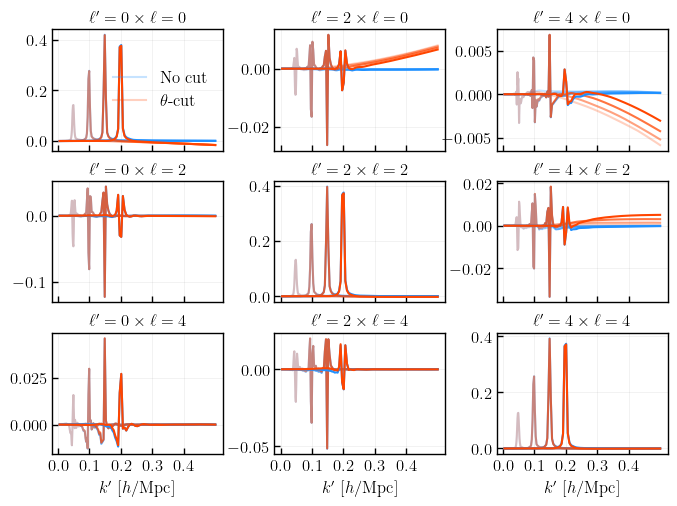

In [4]:
kobs = [0.05, 0.1, 0.15, 0.2]
alphas = [0.25, 0.5, 0.75, 1]

if rpcut:
    cutlabel = r'$r_{\perp}$-cut'
elif thetacut:
    cutlabel = r'$\theta$-cut'

fig, lax = plt.subplots(len(wm.projsout), len(wm.projsin), figsize=(7, 5), sharey=False, sharex=True)

for i in range(len(kobs)):

    indexout = np.abs(wm.xout[0] - kobs[i]).argmin()

    for iin, projin in enumerate(wm.projsin):
        for iout, projout in enumerate(wm.projsout):
            ax = lax[iout][iin]
            ax.plot(wm.xin[iin], wm.unpacked()[iin][iout][:, indexout], label=r'No cut' if i==0 else '', color='C0', alpha=alphas[i])
            ax.plot(wm_cut.xin[iin], wm_cut.unpacked()[iin][iout][:, indexout], label=cutlabel if i==0 else '', ls='-', color='C1', alpha=alphas[i])
            ax.xaxis.set_ticks(np.arange(0, min(np.max(wm.xin[iin]), ktmax), min(np.max(wm.xin[iin]), ktmax)/5))
            ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
            ax.set_title(r'$\ell^\prime = {:d} \times \ell = {:d}$'.format(projin.ell, projout.ell))
            #ax.text(0.05, 0.95, r'$\ell^\prime = {:d} \times \ell = {:d}$'.format(projin.ell, projout.ell), horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, color='black')
            if iout == len(wm.projsout) - 1: ax.set_xlabel(r'$k^\prime$ [$h/\mathrm{Mpc}$]')
            if i==0 and iin == 0 and iout == 0: lax[iout][iin].legend()
plt.subplots_adjust(wspace=0.3, hspace=0.25)
plt.savefig(os.path.join(plots_dir, version, 'wmatrix_{}cut{}_{}_{}_{}_ktmax{}.pdf'.format('rp' if rpcut else 'theta', max(rpcut, thetacut), tracer, region, 'complete' if completeness else 'fa', ktmax)), dpi=200)
plt.show()

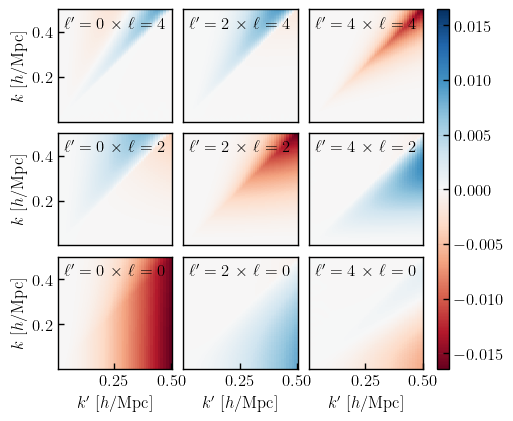

In [5]:
diff = [[a_cut - a for a, a_cut in zip(b, b_cut)] for b, b_cut in zip(wm.unpacked(), wm_cut.unpacked())]

from matplotlib import colors
divnorm=colors.CenteredNorm()
                                     
plot_matrix(diff, figsize=(4.5, 4.5), norm=divnorm, x1=wm.xin, x2=wm.xout, xlabel1=r'$k^\prime$ [$h/\mathrm{Mpc}$]', xlabel2=r'$k$ [$h/\mathrm{Mpc}$]',
            barlabel=None, label1=[r'$\ell^\prime = {:d}$'.format(proj.ell) for proj in wm.projsin], label2=[r'$\ell = {:d}$'.format(proj.ell) for proj in wm.projsout])
plt.savefig(os.path.join(plots_dir, version, 'wmatrix_{}cut{}_diff_{}_{}_z{:.2f}-{:.2f}_ktmax{}.png'.format('rp' if rpcut else 'theta', max(rpcut, thetacut), tracer, region, zrange[0], zrange[1], ktmax)), dpi=300)
plt.show()

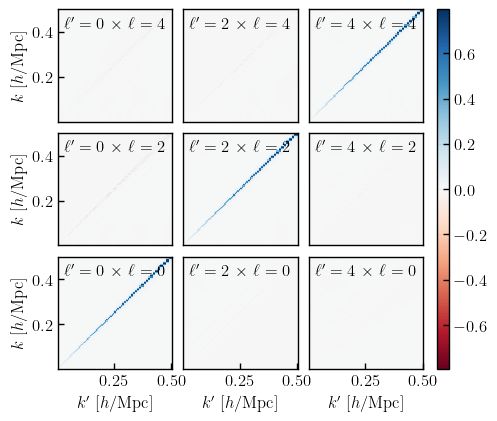

In [6]:
from matplotlib import colors

norm = colors.CenteredNorm()

plot_matrix(wm.unpacked(), figsize=(4.5, 4.5), norm=norm, x1=wm.xin, x2=wm.xout, xlabel1=r'$k^\prime$ [$h/\mathrm{Mpc}$]', xlabel2=r'$k$ [$h/\mathrm{Mpc}$]',
            barlabel=None, label1=[r'$\ell^\prime = {:d}$'.format(proj.ell) for proj in wm.projsin], label2=[r'$\ell = {:d}$'.format(proj.ell) for proj in wm.projsout])
plt.savefig(os.path.join(plots_dir, version, 'wmatrix_{}_{}_z{:.2f}-{:.2f}_ktmax{}.png'.format(tracer, region, zrange[0], zrange[1], ktmax)), dpi=300)
plt.show()

## Test with constant theory

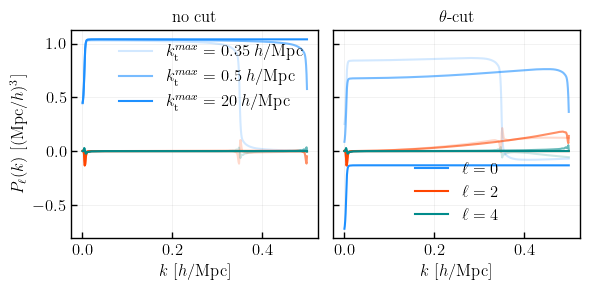

In [7]:
plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True, sharex=True)

for alpha, ktmax in zip([0.2, 0.6, 1], [0.35, 0.5, 20]):
    wm = BaseMatrix.load(wm_fn.get_path(rpcut=0., thetacut=0.))
    wm_cut = BaseMatrix.load(wm_fn.get_path(rpcut=rpcut, thetacut=thetacut))
    for w in [wm, wm_cut]:
        w.select_x(xoutlim=(krange[0], krange[1]))
        w.select_x(xinlim=(0.005, ktmax))
    shotnoise_theory = np.zeros(wm.shape[0])
    shotnoise_theory[:wm.shape[0]//len(ells)] = 1
    pkobs = wm.value.T.dot(shotnoise_theory).reshape((len(ells), wm.shape[1]//len(ells)))
    pkobs_cut = wm_cut.value.T.dot(shotnoise_theory).reshape((len(ells), wm_cut.shape[1]//len(ells)))

    for ill, ell in enumerate([0, 2, 4]):
        axes[0].plot(wm.xout[ill], pkobs[ill], color='C{}'.format(ill), alpha=alpha)
        axes[1].plot(wm_cut.xout[ill], pkobs_cut[ill], color='C{}'.format(ill), label=r'$\ell = {}$'.format(ell) if alpha==1 else '', alpha=alpha)
    axes[0].plot([], [], alpha=alpha, color='C0', label=r'$k_{{\mathrm{{t}}}}^{{max}} = {} \; h/\mathrm{{Mpc}}$'.format(ktmax))
axes[0].set_ylabel(r'$P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
axes[0].set_title(r'no cut')
axes[1].set_title(cutlabel)
axes[0].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
axes[1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
axes[0].legend()
axes[1].legend()
#plt.savefig(os.path.join(plots_dir, 'wmatrix_csttheory_rpcut_directedges_ktmax20.png'), dpi=300)
plt.show()

# Configuration space window function

In [8]:
window_fn = DESIFileName()
window_fn.set_default_config(version=version, ftype='window_smooth', tracer=tracer, region=region, completeness=completeness, zrange=zrange, realization='merged', thetacut=thetacut,
                            baseline=False, weighting='_default_FKP_lin', nran=18, cellsize=6, boxsize=9000)
from pypower import PowerSpectrumSmoothWindow
window = PowerSpectrumSmoothWindow.concatenate_x([PowerSpectrumSmoothWindow.load(window_fn.get_path(boxscale=scale)) for scale in [1, 5, 20]], frac_nyq=0.9) # Here we remove the range above 0.9 Nyquist (which may not be reliable)

In [9]:
window_nocut = window.copy()
window_nocut.corr_direct_nonorm = 0

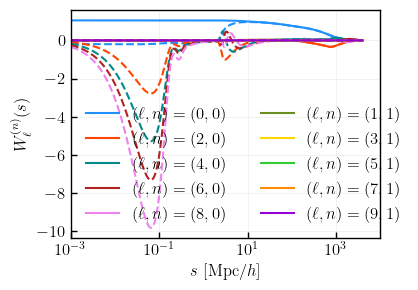

In [10]:
sep = np.geomspace(1e-3, 4e3, 2048)
window_real = window.to_real(sep=sep)
window_nocut_real = window_nocut.to_real(sep=sep)

plt.figure(figsize=(4, 3))
             
ax = plt.gca()
for iproj, proj in enumerate(window_real.projs):
    ax.plot(window_real.sep, window_real(proj=proj), linestyle='--', color='C{:d}'.format(iproj))
    ax.plot(window_nocut_real.sep, window_nocut_real(proj=proj), linestyle='-', color='C{:d}'.format(iproj), label=proj.latex(inline=True))
ax.set_xlim(sep[0], 1e4)
ax.set_xscale('log')
ax.set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
ax.set_ylabel(r'$W_{\ell}^{(n)}(s)$')
plt.legend(ncol=2)
plt.show()

In [25]:
from pycorr import TwoPointCounter

corr = TwoPointCounter.load('/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/v4_1/paircounts/rrcounts_smu_mock0_ELG_LOP_complete_SGC_1.1_1.6_WEIGHT_smax1.npy')

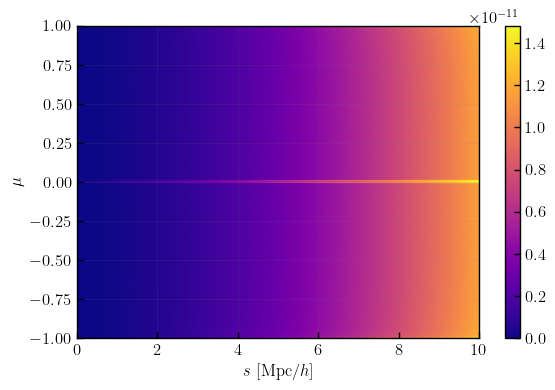

In [27]:
extent = 0, 10, -1, 1
plt.imshow(corr.wcounts.T/corr.wnorm, extent=extent, aspect='auto')
plt.xlabel(r'$s$ [Mpc/$h$]')
plt.ylabel(r'$\mu$')
plt.colorbar()
plt.show()